In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main figure is with 1 Million simulations

In [3]:
gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_06__09_59_25_m/0_nsims_1000000"
npe_path = "/home/michael/Documents/neuralgbi/results/hh/npe/2023_05_07__12_29_21"

In [4]:
with open(f"{gbi_path}/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)
with open(f"{npe_path}/inference_npe.pkl", "rb") as handle:
    inference_npe = pickle.load(handle)

### Load simulator

In [5]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [6]:
true_params, labels_params = utils.obs_params(reduced_model=False)
I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=0, cython=True)

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

### Load prior

In [7]:
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

### Generate synthetic xo

In [16]:
# Generate 1 simulations for 10 thetas
_ = torch.manual_seed(111)

theta_vals = prior.sample((5,))
seeds = torch.randint(0, 100000, (5,))
all_stats = []
all_sims_xo = []
for theta_ind, theta_val in enumerate(theta_vals):
    x_val = sim.gen_single(theta_val, seed=seeds[theta_ind])
    all_sims_xo.append(x_val)
    summstats = stats.calc([x_val])
    all_stats.append(summstats)

all_stats = np.asarray(all_stats)
obs_stats_ls = torch.as_tensor(all_stats, dtype=torch.float32)

### Load data

In [17]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

# GBI

### Evaluate the distance estimator

In [18]:
_ = torch.manual_seed(222)

# Generate 10 simulations for 100 thetas
theta_vals = prior.sample((100,))
seeds = torch.randint(0, 100000, (100, 10))
final_stats = []
for theta_ind, theta_val in enumerate(theta_vals):
    all_summstats = []
    for iter_ in range(10):  # 10 sims per theta
        x_val = sim.gen_single(theta_val, seed=seeds[theta_ind, iter_])
        summstats = stats.calc([x_val])
        all_summstats.append(summstats)
    final_stats.append(all_summstats)

final_stats = np.asarray(final_stats)
final_stats = torch.as_tensor(final_stats, dtype=torch.float32)
final_stats = final_stats.squeeze()
print("final_stats", final_stats.shape)

final_stats torch.Size([100, 10, 7])


In [19]:
pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in obs_stats_ls])
true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in obs_stats_ls])

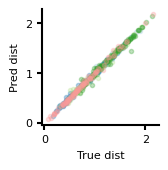

In [79]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
    for i in range(5):
        t = true_dists[i]
        p = pred_dists[i]
        _ = ax.scatter(t, p, c=cols[i], alpha=.3)
        _ = ax.set_xlabel("True dist")
        _ = ax.set_ylabel("Pred dist")
    plt.savefig("svg/panel_a.svg")

### Draw samples from posterior

In [24]:
def sample_gbi_all_xo(beta):
    all_samples = []
    for xo in obs_stats_ls:
        xo = as_tensor(xo)
        potential_fn = inference_gbi.get_potential(x_o=xo, beta=beta)
        theta_transform = mcmc_transform(prior)

        posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
            frac_chains_to_finish=0.9,
        )
        posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)
        all_samples.append(posterior_samples)
    return all_samples

In [25]:
betas = [4.0, 10.0, 25.0]

In [26]:
_ = torch.manual_seed(333)
samples_gbi_synth_beta10 = sample_gbi_all_xo(betas[0])

_ = torch.manual_seed(444)
samples_gbi_synth_beta50 = sample_gbi_all_xo(betas[1])

_ = torch.manual_seed(555)
samples_gbi_synth_beta250 = sample_gbi_all_xo(betas[2])

with open("samples_gbi_synth_beta10.pkl", "wb") as handle:
    pickle.dump(samples_gbi_synth_beta10, handle)
with open("samples_gbi_synth_beta50.pkl", "wb") as handle:
    pickle.dump(samples_gbi_synth_beta50, handle)
with open("samples_gbi_synth_beta250.pkl", "wb") as handle:
    pickle.dump(samples_gbi_synth_beta250, handle)

Running vectorized MCMC with 100 chains:  99%|██████████████████████████████████████████████████▋| 60830/61200 [01:38<00:00, 617.11it/s]


In [27]:
with open("samples_gbi_synth_beta10.pkl", "rb") as handle:
    samples_gbi_synth_beta10 = pickle.load(handle)
with open("samples_gbi_synth_beta50.pkl", "rb") as handle:
    samples_gbi_synth_beta50 = pickle.load(handle)
with open("samples_gbi_synth_beta250.pkl", "rb") as handle:
    samples_gbi_synth_beta250 = pickle.load(handle)

### Posterior predictives

In [29]:
all_predictive_stats_gbi250 = []
all_predictive_traces_gbi250 = []
for posterior_samples in samples_gbi_synth_beta250:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi250.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi250.append(r)

all_predictive_stats_gbi50 = []
all_predictive_traces_gbi50 = []
for posterior_samples in samples_gbi_synth_beta50:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi50.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi50.append(r)

all_predictive_stats_gbi10 = []
all_predictive_traces_gbi10 = []
for posterior_samples in samples_gbi_synth_beta10:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi10.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi10.append(r)

In [55]:
gbi250_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi250, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi250_av_dists.append(torch.mean(dists))

gbi50_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi50, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi50_av_dists.append(torch.mean(dists))

gbi10_av_dists = []
for predictives, xo in zip(all_predictive_stats_gbi10, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi10_av_dists.append(torch.mean(dists))

### Beta = low

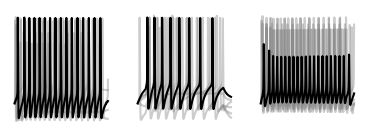

In [96]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
    for i in range(3):
        predictives = all_predictive_traces_gbi10[i]
        xo = all_sims_xo[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)    
        _ = ax[i].plot(sim.t, xo["data"], c="k")
        
        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

### Beta = medium

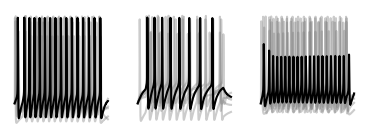

In [97]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
    for i in range(3):
        predictives = all_predictive_traces_gbi50[i]
        xo = all_sims_xo[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)    
        _ = ax[i].plot(sim.t, xo["data"], c="k")
        
        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

### Beta = high

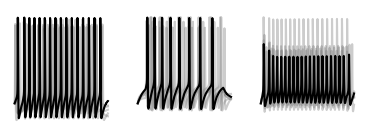

In [98]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
    for i in range(3):
        predictives = all_predictive_traces_gbi250[i]
        xo = all_sims_xo[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)    
        _ = ax[i].plot(sim.t, xo["data"], c="k")

        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
        
    plt.savefig("svg/panel_b.svg")

# NPE

In [119]:
_ = torch.manual_seed(666)
npe_all_samples = []
maps = []
for xo in obs_stats_ls:
    xo = as_tensor(xo)
    posterior = inference_npe.build_posterior()
    posterior_samples = posterior.sample((1_000,), x=xo)
    npe_all_samples.append(posterior_samples)

Drawing 1000 posterior samples: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 32689.09it/s]


In [120]:
all_predictive_traces_npe = []
all_predictive_stats_npe = []
for thetas in npe_all_samples:
    r = [sim.gen_single(theta.numpy(), seed=2) for theta in thetas[:100]]
    all_predictive_traces_npe.append(r)
    stats_ = stats.calc(r)
    all_predictive_stats_npe.append(torch.as_tensor(stats_, dtype=torch.float32))

In [121]:
npe_av_dists = []
for predictives, xo in zip(all_predictive_stats_npe, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

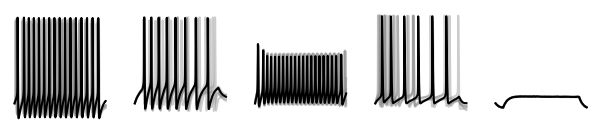

In [122]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 5, figsize=(7.5, 1.5))
    for i in range(5):
        predictives = all_predictive_traces_npe[i]
        xo = all_sims_xo[i]
        for p in predictives[:5]:
            _ = ax[i].plot(sim.t, p["data"], c="grey", alpha=0.4)    
        _ = ax[i].plot(sim.t, xo["data"], c="k")
        
        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

# Compare NPE and GBI

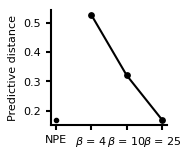

In [123]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
    _ = ax.scatter([0], [np.mean(npe_av_dists)], c="k")
    _ = ax.plot([1, 2, 3], [np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists)])
    _ = ax.scatter([1, 2, 3], [np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists)], s=15)
    _ = ax.set_xticks([0, 1, 2, 3])
    _ = ax.set_xticklabels(["NPE", r"$\beta$ = 4", r"$\beta$ = 10", r"$\beta$ = 25"])
    _ = ax.set_ylabel("Predictive distance")
    plt.savefig("svg/panel_c.svg")

/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(


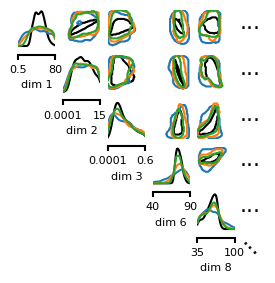

In [124]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = pairplot(
        [
            npe_all_samples[0], 
            samples_gbi_synth_beta10[0], 
            samples_gbi_synth_beta50[0], 
            samples_gbi_synth_beta250[0], 
        ],
        limits=limits,
        ticks=limits,
        upper="contour",
        contour_offdiag={"levels": [0.68], "percentile": True},
        figsize=(2.8, 2.8),
        diag="kde",
        subset=[0, 1, 2, 5, 7]
    )
    plt.savefig("svg/panel_d.svg")

### Assemble figure

In [125]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [126]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("17.3cm", "8.1cm",
    
#     Panel(
#           SVG("svg/illustration.svg").scale(0.6),
#           Text("a", -5, 2.0, **kwargs_text),
#     ).move(10, 20),
    
    Panel(
          SVG("svg/panel_a.svg").scale(svg_scale),
          Text("a", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("svg/panel_c.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(200, 20),
    
    Panel(
          SVG("svg/panel_b.svg").scale(svg_scale),
          Text("c", -5, 2.0, **kwargs_text),
    ).move(20, 170),
    
    Panel(
          SVG("svg/panel_d.svg").scale(svg_scale),
          Text("d", -5, 2.0, **kwargs_text),
    ).move(400, 20),
)

!mkdir -p fig
f.save("fig/fig.svg")
svg("fig/fig.svg")